In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [3]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('nasdaq_1.csv')
df

,Date,Close
0,1985/1/1,278.700012
1,1985/2/1,284.200012
2,1985/3/1,279.200012
3,1985/4/1,280.600006
4,1985/5/1,290.799988
...,...,...
457,2023/2/1,11455.540040
458,2023/3/1,12221.910160
459,2023/4/1,12226.580080
460,2023/5/1,12935.290040


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [4]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    462 non-null    object 
 1   Close   462 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.3+ KB


In [5]:
new_df=df.iloc[:,[0,1]].copy()
new_df.head()

,Date,Close
0,1985/1/1,278.700012
1,1985/2/1,284.200012
2,1985/3/1,279.200012
3,1985/4/1,280.600006
4,1985/5/1,290.799988


In [6]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Close
count,462.000000
mean,3259.631206
std,3475.334534
min,278.700012
25%,768.414993
50%,2112.260009
75%,4161.082398
max,15644.969730


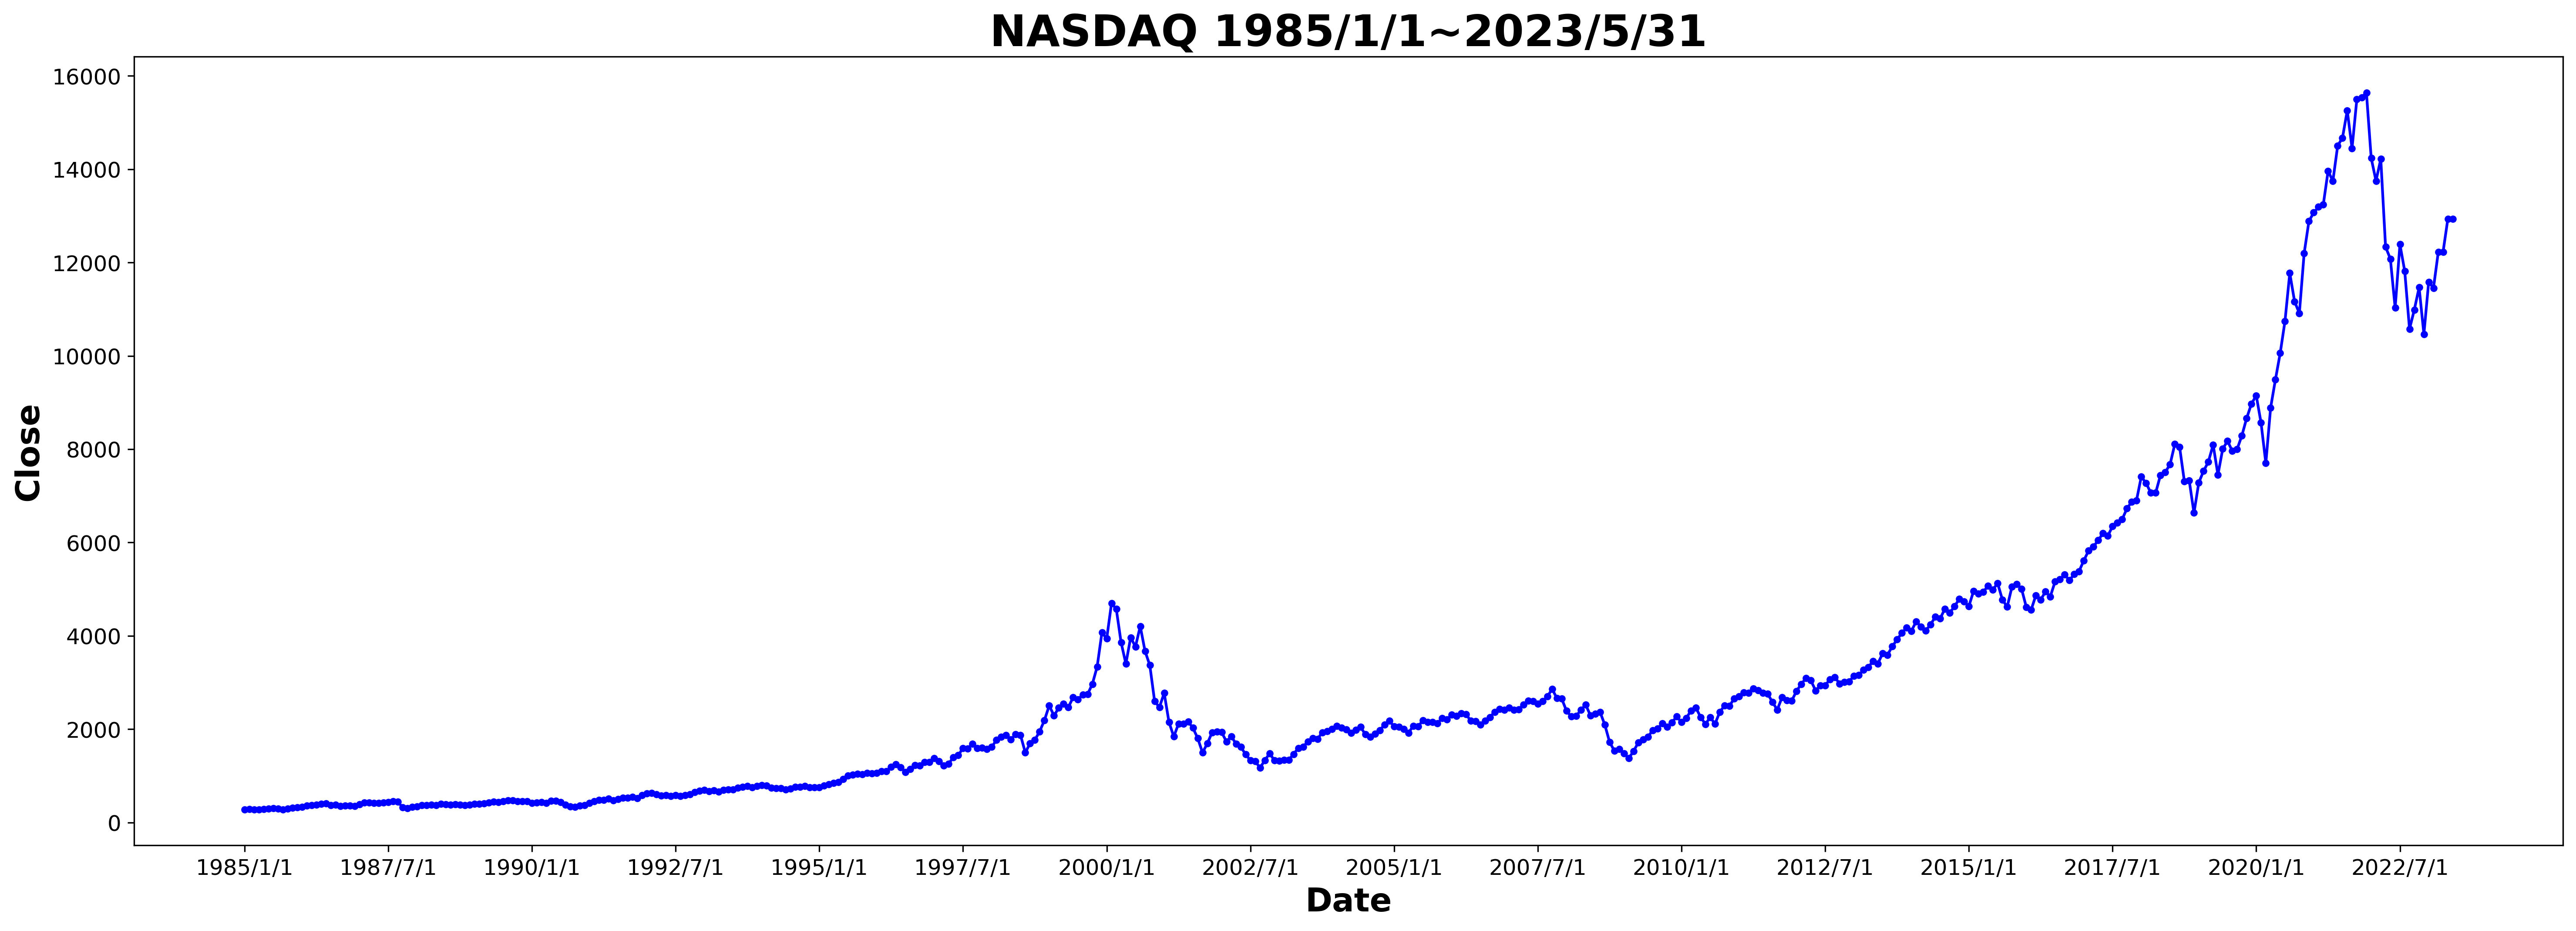

In [7]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('NASDAQ 1985/1/1~2023/5/31',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(df['Date'][::30],fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [8]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,1985/1/1,278.700012,NaN,NaN,NaN
1,1985/2/1,284.200012,278.700012,NaN,NaN
2,1985/3/1,279.200012,284.200012,278.700012,NaN
3,1985/4/1,280.600006,279.200012,284.200012,278.700012
4,1985/5/1,290.799988,280.600006,279.200012,284.200012


In [9]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,1985/4/1,280.600006,279.200012,284.200012,278.700012
1,1985/5/1,290.799988,280.600006,279.200012,284.200012
2,1985/6/1,296.200012,290.799988,280.600006,279.200012
3,1985/7/1,301.299988,296.200012,290.799988,280.600006
4,1985/8/1,297.700012,301.299988,296.200012,290.799988
...,...,...,...,...,...
454,2023/2/1,11455.540040,11584.549810,10466.480470,11468.000000
455,2023/3/1,12221.910160,11455.540040,11584.549810,10466.480470
456,2023/4/1,12226.580080,12221.910160,11455.540040,11584.549810
457,2023/5/1,12935.290040,12226.580080,12221.910160,11455.540040


In [12]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [10]:
# Train data
Forecast_train_data=clean_df.iloc[0:459,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,1985/4/1,280.600006,279.200012,284.200012,278.700012
1,1985/5/1,290.799988,280.600006,279.200012,284.200012
2,1985/6/1,296.200012,290.799988,280.600006,279.200012
3,1985/7/1,301.299988,296.200012,290.799988,280.600006
4,1985/8/1,297.700012,301.299988,296.200012,290.799988
...,...,...,...,...,...
454,2023/2/1,11455.540040,11584.549810,10466.480470,11468.000000
455,2023/3/1,12221.910160,11455.540040,11584.549810,10466.480470
456,2023/4/1,12226.580080,12221.910160,11455.540040,11584.549810
457,2023/5/1,12935.290040,12226.580080,12221.910160,11455.540040


In [11]:
# Test data
Forecast_test_data=clean_df.iloc[367:367+92,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
367,2015/11/1,5108.669922,5053.750000,4620.160156,4776.509766
368,2015/12/1,5007.410156,5108.669922,5053.750000,4620.160156
369,2016/1/1,4613.950195,5007.410156,5108.669922,5053.750000
370,2016/2/1,4557.950195,4613.950195,5007.410156,5108.669922
371,2016/3/1,4869.850098,4557.950195,4613.950195,5007.410156
...,...,...,...,...,...
454,2023/2/1,11455.540040,11584.549810,10466.480470,11468.000000
455,2023/3/1,12221.910160,11455.540040,11584.549810,10466.480470
456,2023/4/1,12226.580080,12221.910160,11455.540040,11584.549810
457,2023/5/1,12935.290040,12226.580080,12221.910160,11455.540040


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

In [225]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:183,:].copy()
Exp_val_1=Forecast_train_data.iloc[183:183+61,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:244,:].copy()
Exp_val_2=Forecast_train_data.iloc[244:244+61,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:305,:].copy()
Exp_val_3=Forecast_train_data.iloc[305:305+62,:].copy()

# Rolling window

In [134]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:183,:].copy()
Rol_val_1=Forecast_train_data.iloc[183:183+61,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[61:244,:].copy()
Rol_val_2=Forecast_train_data.iloc[244:244+61,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[122:305,:].copy()
Rol_val_3=Forecast_train_data.iloc[305:305+62,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [226]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()

In [135]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

# 6. Creating Net 

In [227]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.000000,0.001132,0.000000
1,0.000317,0.000000,0.001245
2,0.002626,0.000317,0.000113
3,0.003848,0.002626,0.000430
4,0.005003,0.003848,0.002739


In [228]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [230]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [231]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=24, activation='linear'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=48, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=96, activation='relu'))


# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.00001,momentum=0.9)
opt=Adam(learning_rate=0.00001,beta_1=0.9,beta_2=0.999)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [232]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
5/5 [==============================] - 0s 43ms/step - loss: 1429.5187 - mean_absolute_percentage_error: 100.0009 - val_loss: 3599.9995 - val_mean_absolute_percentage_error: 99.9994
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 1429.5206 - mean_absolute_percentage_error: 100.0010 - val_loss: 3599.9968 - val_mean_absolute_percentage_error: 99.9994
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 1429.5159 - mean_absolute_percentage_error: 100.0006 - val_loss: 3599.9939 - val_mean_absolute_percentage_error: 99.9993
Epoch 4/300
5/5 [==============================] - 0s 11ms/step - loss: 1429.5178 - mean_absolute_percentage_error: 100.0006 - val_loss: 3599.9912 - val_mean_absolute_percentage_error: 99.9992
Epoch 5/300
5/5 [==============================] - 0s 10ms/step - loss: 1429.5093 - mean_absolute_percentage_error: 100.0002 - val_loss: 3599.9885 - val_mean_absolute_percentage_error: 99.9991
Epoch 6/300
5/5 [==================

5/5 [==============================] - 0s 11ms/step - loss: 1429.4496 - mean_absolute_percentage_error: 99.9951 - val_loss: 3599.8843 - val_mean_absolute_percentage_error: 99.9964
Epoch 44/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.4373 - mean_absolute_percentage_error: 99.9944 - val_loss: 3599.8816 - val_mean_absolute_percentage_error: 99.9963
Epoch 45/300
5/5 [==============================] - 0s 10ms/step - loss: 1429.4423 - mean_absolute_percentage_error: 99.9945 - val_loss: 3599.8784 - val_mean_absolute_percentage_error: 99.9962
Epoch 46/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.4427 - mean_absolute_percentage_error: 99.9947 - val_loss: 3599.8757 - val_mean_absolute_percentage_error: 99.9962
Epoch 47/300
5/5 [==============================] - 0s 12ms/step - loss: 1429.4359 - mean_absolute_percentage_error: 99.9942 - val_loss: 3599.8730 - val_mean_absolute_percentage_error: 99.9961
Epoch 48/300
5/5 [==============================] 

Epoch 86/300
5/5 [==============================] - 0s 11ms/step - loss: 1429.3627 - mean_absolute_percentage_error: 99.9881 - val_loss: 3599.7534 - val_mean_absolute_percentage_error: 99.9929
Epoch 87/300
5/5 [==============================] - 0s 11ms/step - loss: 1429.3477 - mean_absolute_percentage_error: 99.9873 - val_loss: 3599.7500 - val_mean_absolute_percentage_error: 99.9929
Epoch 88/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.3490 - mean_absolute_percentage_error: 99.9874 - val_loss: 3599.7468 - val_mean_absolute_percentage_error: 99.9928
Epoch 89/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.3549 - mean_absolute_percentage_error: 99.9875 - val_loss: 3599.7432 - val_mean_absolute_percentage_error: 99.9927
Epoch 90/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.3567 - mean_absolute_percentage_error: 99.9873 - val_loss: 3599.7400 - val_mean_absolute_percentage_error: 99.9926
Epoch 91/300
5/5 [====================

5/5 [==============================] - 0s 10ms/step - loss: 1429.2469 - mean_absolute_percentage_error: 99.9790 - val_loss: 3599.5913 - val_mean_absolute_percentage_error: 99.9886
Epoch 129/300
5/5 [==============================] - 0s 11ms/step - loss: 1429.2614 - mean_absolute_percentage_error: 99.9794 - val_loss: 3599.5869 - val_mean_absolute_percentage_error: 99.9885
Epoch 130/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.2430 - mean_absolute_percentage_error: 99.9787 - val_loss: 3599.5825 - val_mean_absolute_percentage_error: 99.9884
Epoch 131/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.2579 - mean_absolute_percentage_error: 99.9791 - val_loss: 3599.5779 - val_mean_absolute_percentage_error: 99.9883
Epoch 132/300
5/5 [==============================] - 0s 8ms/step - loss: 1429.2305 - mean_absolute_percentage_error: 99.9776 - val_loss: 3599.5735 - val_mean_absolute_percentage_error: 99.9882
Epoch 133/300
5/5 [============================

5/5 [==============================] - 0s 9ms/step - loss: 1429.1265 - mean_absolute_percentage_error: 99.9684 - val_loss: 3599.3850 - val_mean_absolute_percentage_error: 99.9832
Epoch 171/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.1111 - mean_absolute_percentage_error: 99.9676 - val_loss: 3599.3799 - val_mean_absolute_percentage_error: 99.9831
Epoch 172/300
5/5 [==============================] - 0s 11ms/step - loss: 1429.1118 - mean_absolute_percentage_error: 99.9676 - val_loss: 3599.3745 - val_mean_absolute_percentage_error: 99.9829
Epoch 173/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.1116 - mean_absolute_percentage_error: 99.9679 - val_loss: 3599.3689 - val_mean_absolute_percentage_error: 99.9828
Epoch 174/300
5/5 [==============================] - 0s 9ms/step - loss: 1429.1000 - mean_absolute_percentage_error: 99.9670 - val_loss: 3599.3630 - val_mean_absolute_percentage_error: 99.9826
Epoch 175/300
5/5 [=============================

5/5 [==============================] - 0s 9ms/step - loss: 1428.9619 - mean_absolute_percentage_error: 99.9546 - val_loss: 3599.1357 - val_mean_absolute_percentage_error: 99.9766
Epoch 213/300
5/5 [==============================] - 0s 10ms/step - loss: 1428.9492 - mean_absolute_percentage_error: 99.9543 - val_loss: 3599.1294 - val_mean_absolute_percentage_error: 99.9764
Epoch 214/300
5/5 [==============================] - 0s 9ms/step - loss: 1428.9454 - mean_absolute_percentage_error: 99.9529 - val_loss: 3599.1228 - val_mean_absolute_percentage_error: 99.9763
Epoch 215/300
5/5 [==============================] - 0s 9ms/step - loss: 1428.9254 - mean_absolute_percentage_error: 99.9525 - val_loss: 3599.1160 - val_mean_absolute_percentage_error: 99.9761
Epoch 216/300
5/5 [==============================] - 0s 10ms/step - loss: 1428.9282 - mean_absolute_percentage_error: 99.9526 - val_loss: 3599.1091 - val_mean_absolute_percentage_error: 99.9759
Epoch 217/300
5/5 [============================

5/5 [==============================] - 0s 9ms/step - loss: 1428.7012 - mean_absolute_percentage_error: 99.9338 - val_loss: 3598.8284 - val_mean_absolute_percentage_error: 99.9684
Epoch 255/300
5/5 [==============================] - 0s 9ms/step - loss: 1428.7261 - mean_absolute_percentage_error: 99.9351 - val_loss: 3598.8198 - val_mean_absolute_percentage_error: 99.9682
Epoch 256/300
5/5 [==============================] - 0s 10ms/step - loss: 1428.7211 - mean_absolute_percentage_error: 99.9345 - val_loss: 3598.8113 - val_mean_absolute_percentage_error: 99.9680
Epoch 257/300
5/5 [==============================] - 0s 9ms/step - loss: 1428.6978 - mean_absolute_percentage_error: 99.9333 - val_loss: 3598.8030 - val_mean_absolute_percentage_error: 99.9678
Epoch 258/300
5/5 [==============================] - 0s 9ms/step - loss: 1428.7028 - mean_absolute_percentage_error: 99.9333 - val_loss: 3598.7947 - val_mean_absolute_percentage_error: 99.9675
Epoch 259/300
5/5 [=============================

5/5 [==============================] - 0s 9ms/step - loss: 1428.4659 - mean_absolute_percentage_error: 99.9135 - val_loss: 3598.4478 - val_mean_absolute_percentage_error: 99.9583
Epoch 297/300
5/5 [==============================] - 0s 9ms/step - loss: 1428.4637 - mean_absolute_percentage_error: 99.9121 - val_loss: 3598.4377 - val_mean_absolute_percentage_error: 99.9580
Epoch 298/300
5/5 [==============================] - 0s 9ms/step - loss: 1428.4454 - mean_absolute_percentage_error: 99.9113 - val_loss: 3598.4275 - val_mean_absolute_percentage_error: 99.9578
Epoch 299/300
5/5 [==============================] - 0s 7ms/step - loss: 1428.4716 - mean_absolute_percentage_error: 99.9120 - val_loss: 3598.4172 - val_mean_absolute_percentage_error: 99.9575
Epoch 300/300
5/5 [==============================] - 0s 7ms/step - loss: 1428.4391 - mean_absolute_percentage_error: 99.9106 - val_loss: 3598.4070 - val_mean_absolute_percentage_error: 99.9572


In [233]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

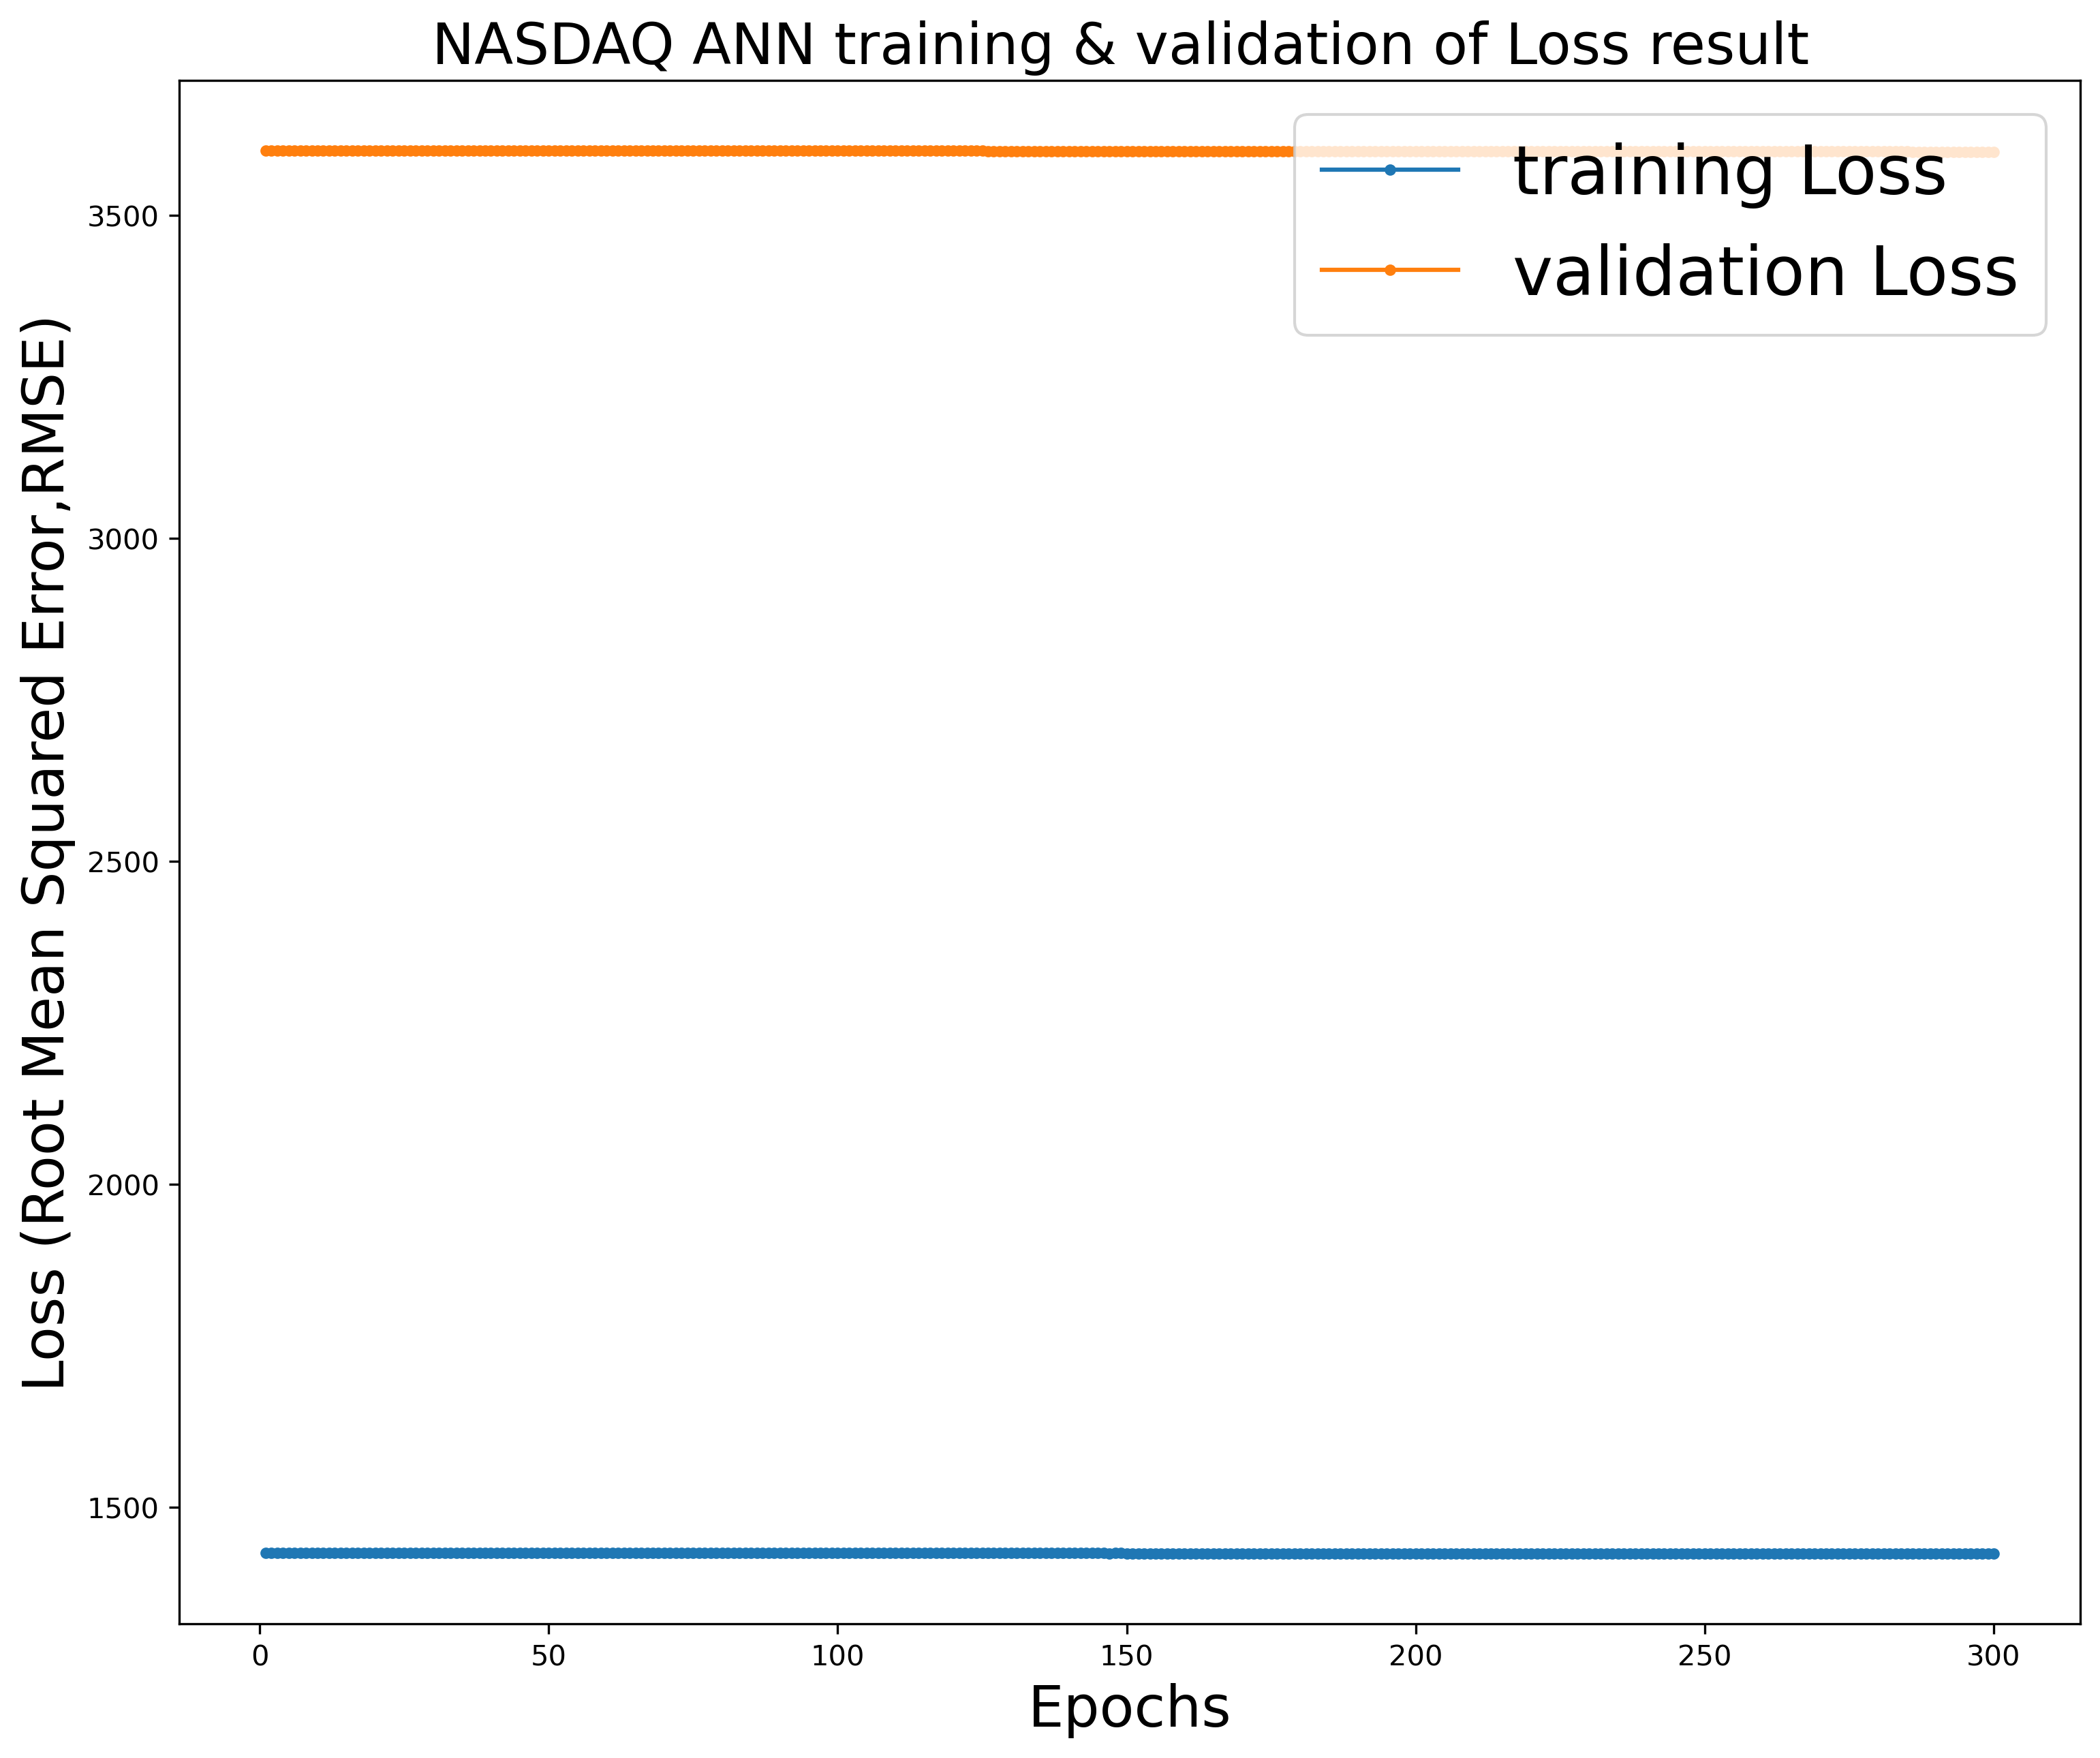

In [234]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('NASDAQ ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

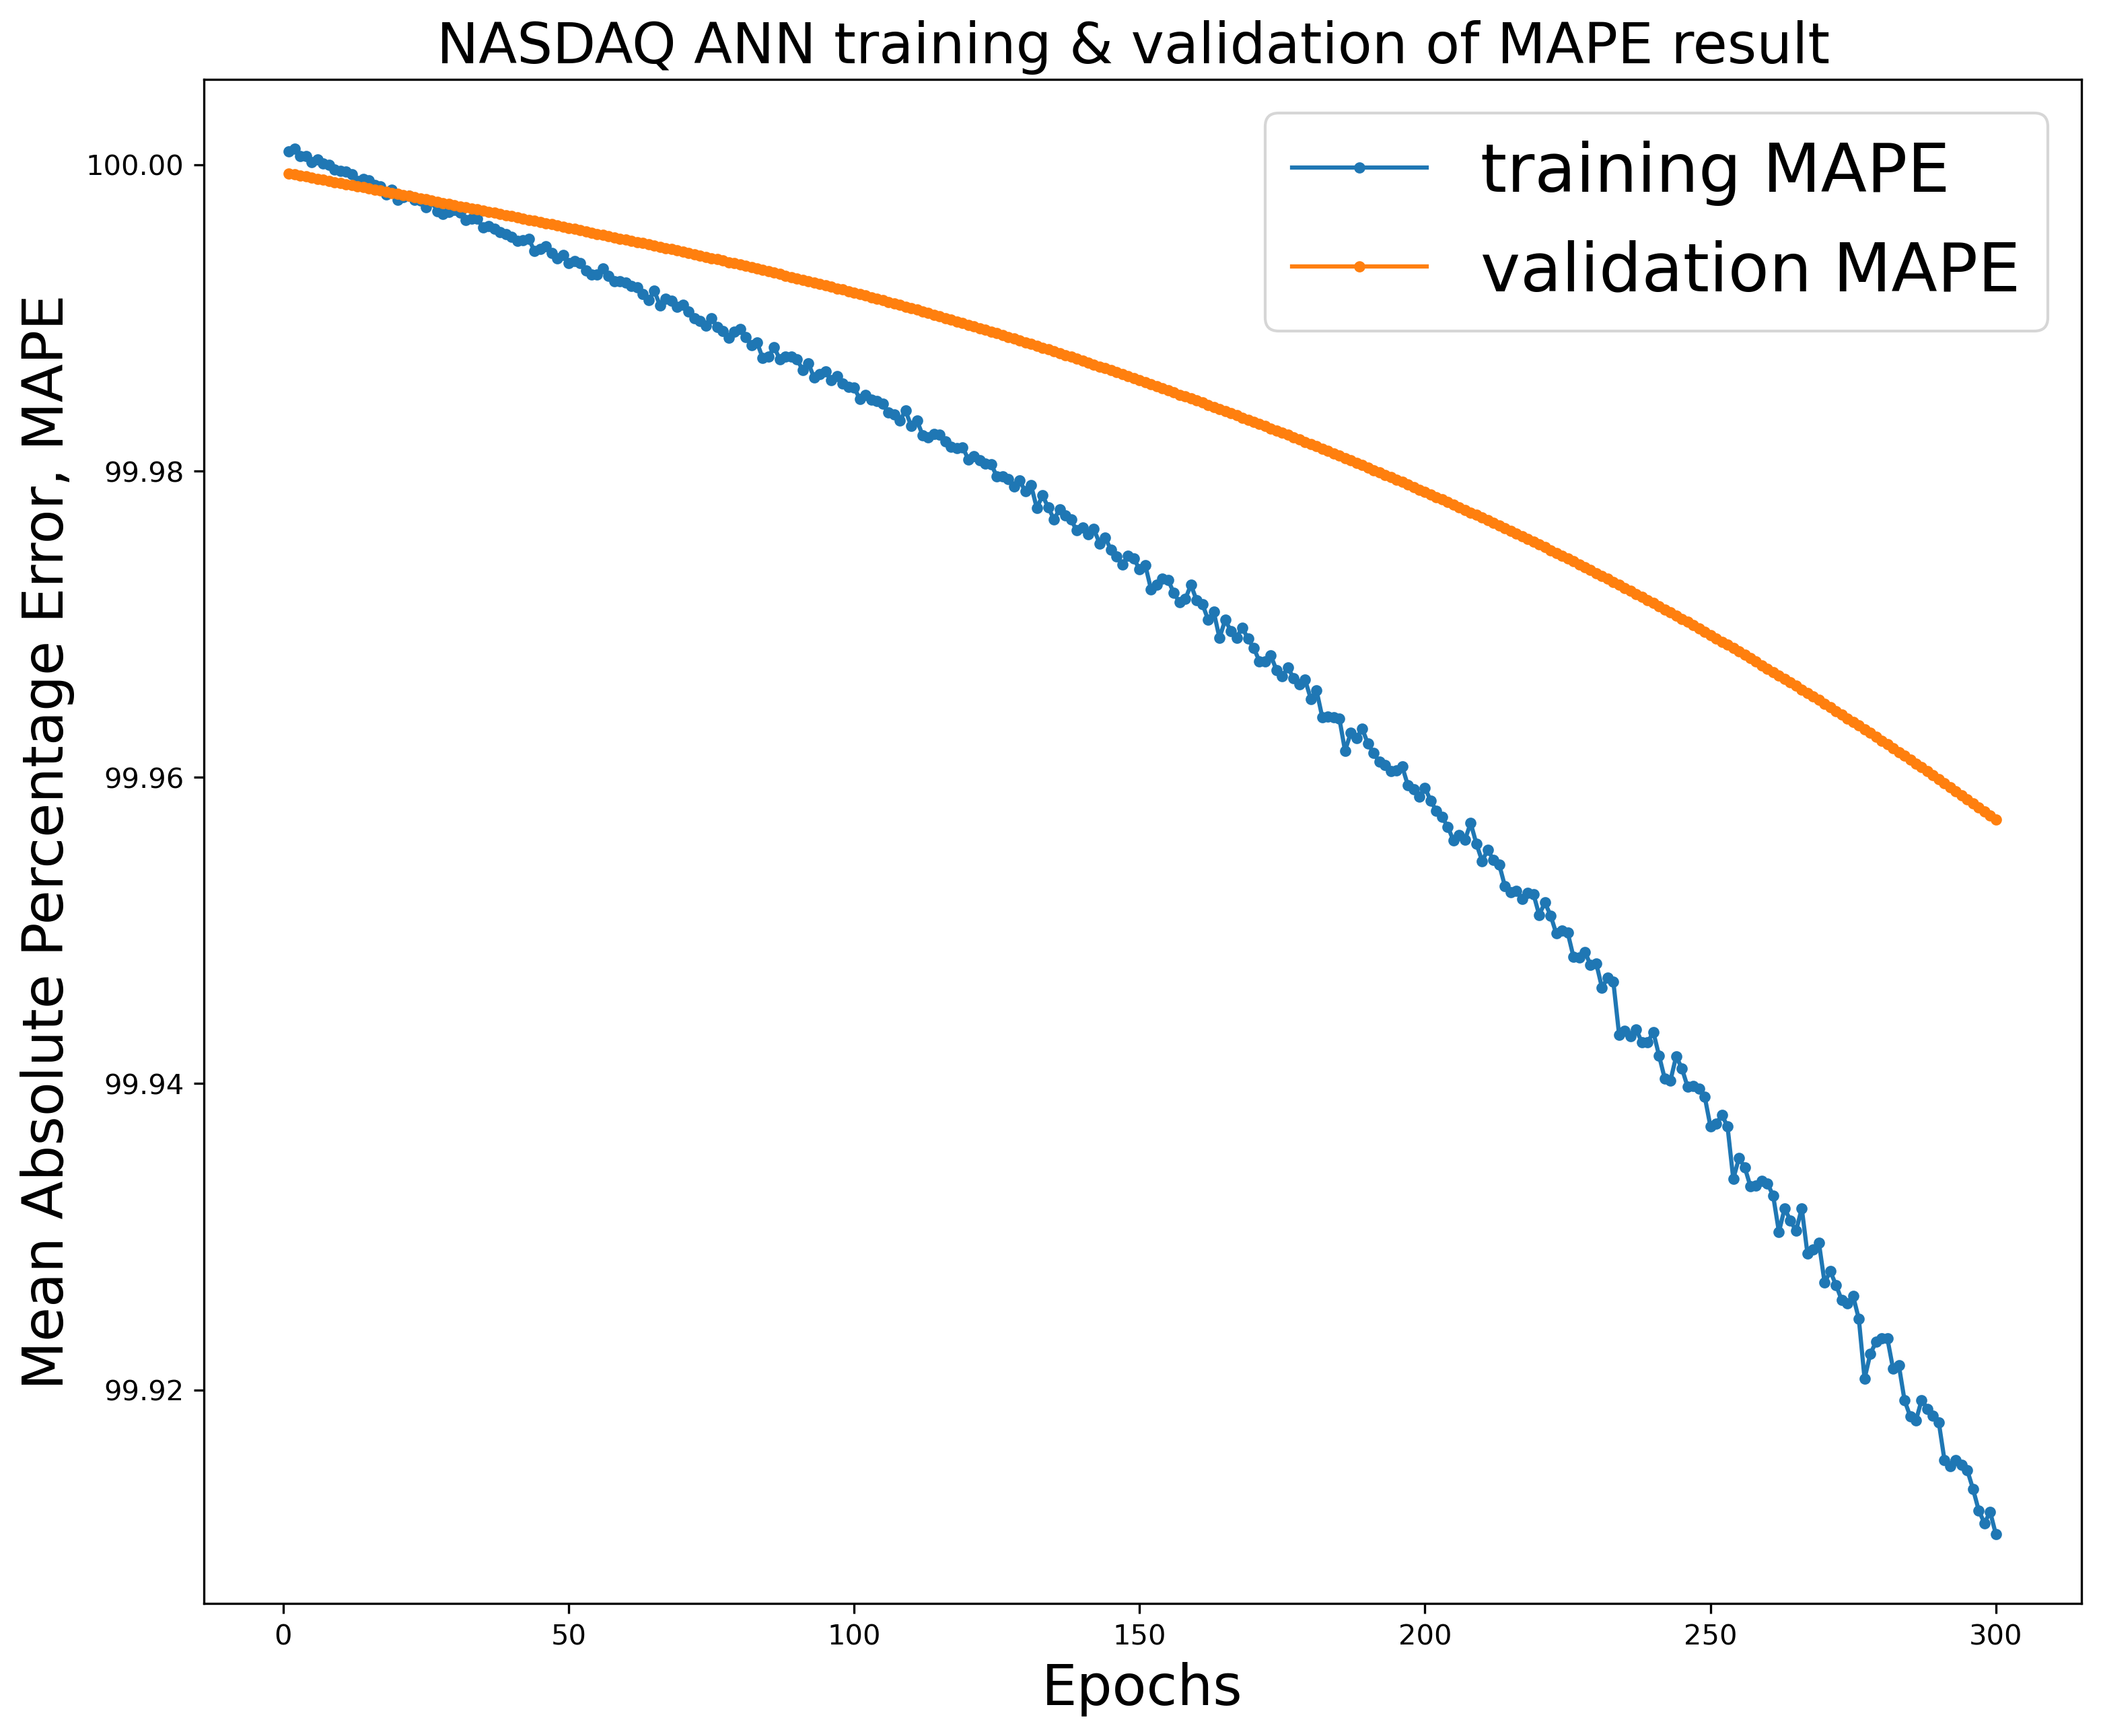

In [235]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('NASDAQ ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [43]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [44]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))
Fmodel.add(Dropout(rate=0.2))
Fmodel.add(Dense(units=24, activation='relu'))
Fmodel.add(Dropout(rate=0.2))
Fmodel.add(Dense(units=48, activation='linear'))
# Add third hidden layer
Fmodel.add(Dense(units=96, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.00001,momentum=0.9)
opt=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4

In [45]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
8/8 [==============================] - 1s 5ms/step - loss: 2592.2666 - mean_absolute_percentage_error: 79.5733
Epoch 2/300
8/8 [==============================] - 0s 5ms/step - loss: 966.2449 - mean_absolute_percentage_error: 29.3896
Epoch 3/300
8/8 [==============================] - 0s 4ms/step - loss: 852.3746 - mean_absolute_percentage_error: 27.0606
Epoch 4/300
8/8 [==============================] - 0s 4ms/step - loss: 675.3037 - mean_absolute_percentage_error: 20.4554
Epoch 5/300
8/8 [==============================] - 0s 3ms/step - loss: 614.4523 - mean_absolute_percentage_error: 19.6722
Epoch 6/300
8/8 [==============================] - 0s 4ms/step - loss: 597.8425 - mean_absolute_percentage_error: 18.9920
Epoch 7/300
8/8 [==============================] - 0s 3ms/step - loss: 478.5655 - mean_absolute_percentage_error: 16.2800
Epoch 8/300
8/8 [==============================] - 0s 5ms/step - loss: 491.8196 - mean_absolute_percentage_error: 14.8309
Epoch 9/300
8/8 [======

8/8 [==============================] - 0s 4ms/step - loss: 242.0869 - mean_absolute_percentage_error: 7.8867
Epoch 68/300
8/8 [==============================] - 0s 4ms/step - loss: 282.4373 - mean_absolute_percentage_error: 8.7195
Epoch 69/300
8/8 [==============================] - 0s 4ms/step - loss: 282.5646 - mean_absolute_percentage_error: 8.9046
Epoch 70/300
8/8 [==============================] - 0s 5ms/step - loss: 257.1837 - mean_absolute_percentage_error: 8.0898
Epoch 71/300
8/8 [==============================] - 0s 4ms/step - loss: 295.3086 - mean_absolute_percentage_error: 8.4044
Epoch 72/300
8/8 [==============================] - 0s 4ms/step - loss: 287.0052 - mean_absolute_percentage_error: 8.7033
Epoch 73/300
8/8 [==============================] - 0s 3ms/step - loss: 280.7243 - mean_absolute_percentage_error: 8.6645
Epoch 74/300
8/8 [==============================] - 0s 3ms/step - loss: 261.3705 - mean_absolute_percentage_error: 8.2559
Epoch 75/300
8/8 [===================

Epoch 134/300
8/8 [==============================] - 0s 5ms/step - loss: 228.4550 - mean_absolute_percentage_error: 7.5377
Epoch 135/300
8/8 [==============================] - 0s 4ms/step - loss: 254.5672 - mean_absolute_percentage_error: 7.5759
Epoch 136/300
8/8 [==============================] - 0s 4ms/step - loss: 241.4712 - mean_absolute_percentage_error: 7.3983
Epoch 137/300
8/8 [==============================] - 0s 4ms/step - loss: 250.7301 - mean_absolute_percentage_error: 8.1294
Epoch 138/300
8/8 [==============================] - 0s 4ms/step - loss: 235.6864 - mean_absolute_percentage_error: 7.6055
Epoch 139/300
8/8 [==============================] - 0s 3ms/step - loss: 245.6135 - mean_absolute_percentage_error: 7.6888
Epoch 140/300
8/8 [==============================] - 0s 4ms/step - loss: 234.0457 - mean_absolute_percentage_error: 7.2569
Epoch 141/300
8/8 [==============================] - 0s 5ms/step - loss: 224.4126 - mean_absolute_percentage_error: 6.8187
Epoch 142/300
8/

8/8 [==============================] - 0s 3ms/step - loss: 220.6351 - mean_absolute_percentage_error: 6.6839
Epoch 201/300
8/8 [==============================] - 0s 3ms/step - loss: 203.6853 - mean_absolute_percentage_error: 6.5236
Epoch 202/300
8/8 [==============================] - 0s 4ms/step - loss: 216.1368 - mean_absolute_percentage_error: 6.6034
Epoch 203/300
8/8 [==============================] - 0s 5ms/step - loss: 209.4404 - mean_absolute_percentage_error: 6.6167
Epoch 204/300
8/8 [==============================] - 0s 3ms/step - loss: 236.8520 - mean_absolute_percentage_error: 7.3442
Epoch 205/300
8/8 [==============================] - 0s 3ms/step - loss: 234.1812 - mean_absolute_percentage_error: 6.7157
Epoch 206/300
8/8 [==============================] - 0s 3ms/step - loss: 226.8905 - mean_absolute_percentage_error: 7.0853
Epoch 207/300
8/8 [==============================] - 0s 5ms/step - loss: 208.6481 - mean_absolute_percentage_error: 6.6372
Epoch 208/300
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 215.1061 - mean_absolute_percentage_error: 6.8808
Epoch 267/300
8/8 [==============================] - 0s 3ms/step - loss: 214.5597 - mean_absolute_percentage_error: 6.7263
Epoch 268/300
8/8 [==============================] - 0s 4ms/step - loss: 214.7505 - mean_absolute_percentage_error: 6.9721
Epoch 269/300
8/8 [==============================] - 0s 4ms/step - loss: 213.9449 - mean_absolute_percentage_error: 6.7865
Epoch 270/300
8/8 [==============================] - 0s 4ms/step - loss: 223.4338 - mean_absolute_percentage_error: 7.2301
Epoch 271/300
8/8 [==============================] - 0s 3ms/step - loss: 226.5012 - mean_absolute_percentage_error: 7.3423
Epoch 272/300
8/8 [==============================] - 0s 4ms/step - loss: 203.1035 - mean_absolute_percentage_error: 7.0169
Epoch 273/300
8/8 [==============================] - 0s 4ms/step - loss: 252.2049 - mean_absolute_percentage_error: 7.2247
Epoch 274/300
8/8 [===========

In [46]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('NASDAQ_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [47]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('NASDAQ_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [48]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [49]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [50]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Close_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
367,2015/11/1,5108.669922,3309.520020,1799.149902
368,2015/12/1,5007.410156,3341.449951,1665.960205
369,2016/1/1,4613.950195,3278.060059,1335.890136
370,2016/2/1,4557.950195,3027.840088,1530.110107
371,2016/3/1,4869.850098,2990.939941,1878.910157
...,...,...,...,...
454,2023/2/1,11455.540040,7584.790039,3870.750001
455,2023/3/1,12221.910160,7486.919922,4734.990238
456,2023/4/1,12226.580080,7996.839844,4229.740236
457,2023/5/1,12935.290040,7992.669922,4942.620118


In [51]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 3232.345
MSE: 11897765.839
RMSE: 3449.314
MAPE: 35.113 %
SMAPE: 42.701 %
RAE: 1.132
MRAE: 0.012304623686514525
MdRAE: 1.196 bench: 9194.642
RSE: 1.136
RRSE: 1.066


#  Plot for comparing true value & predicted value 

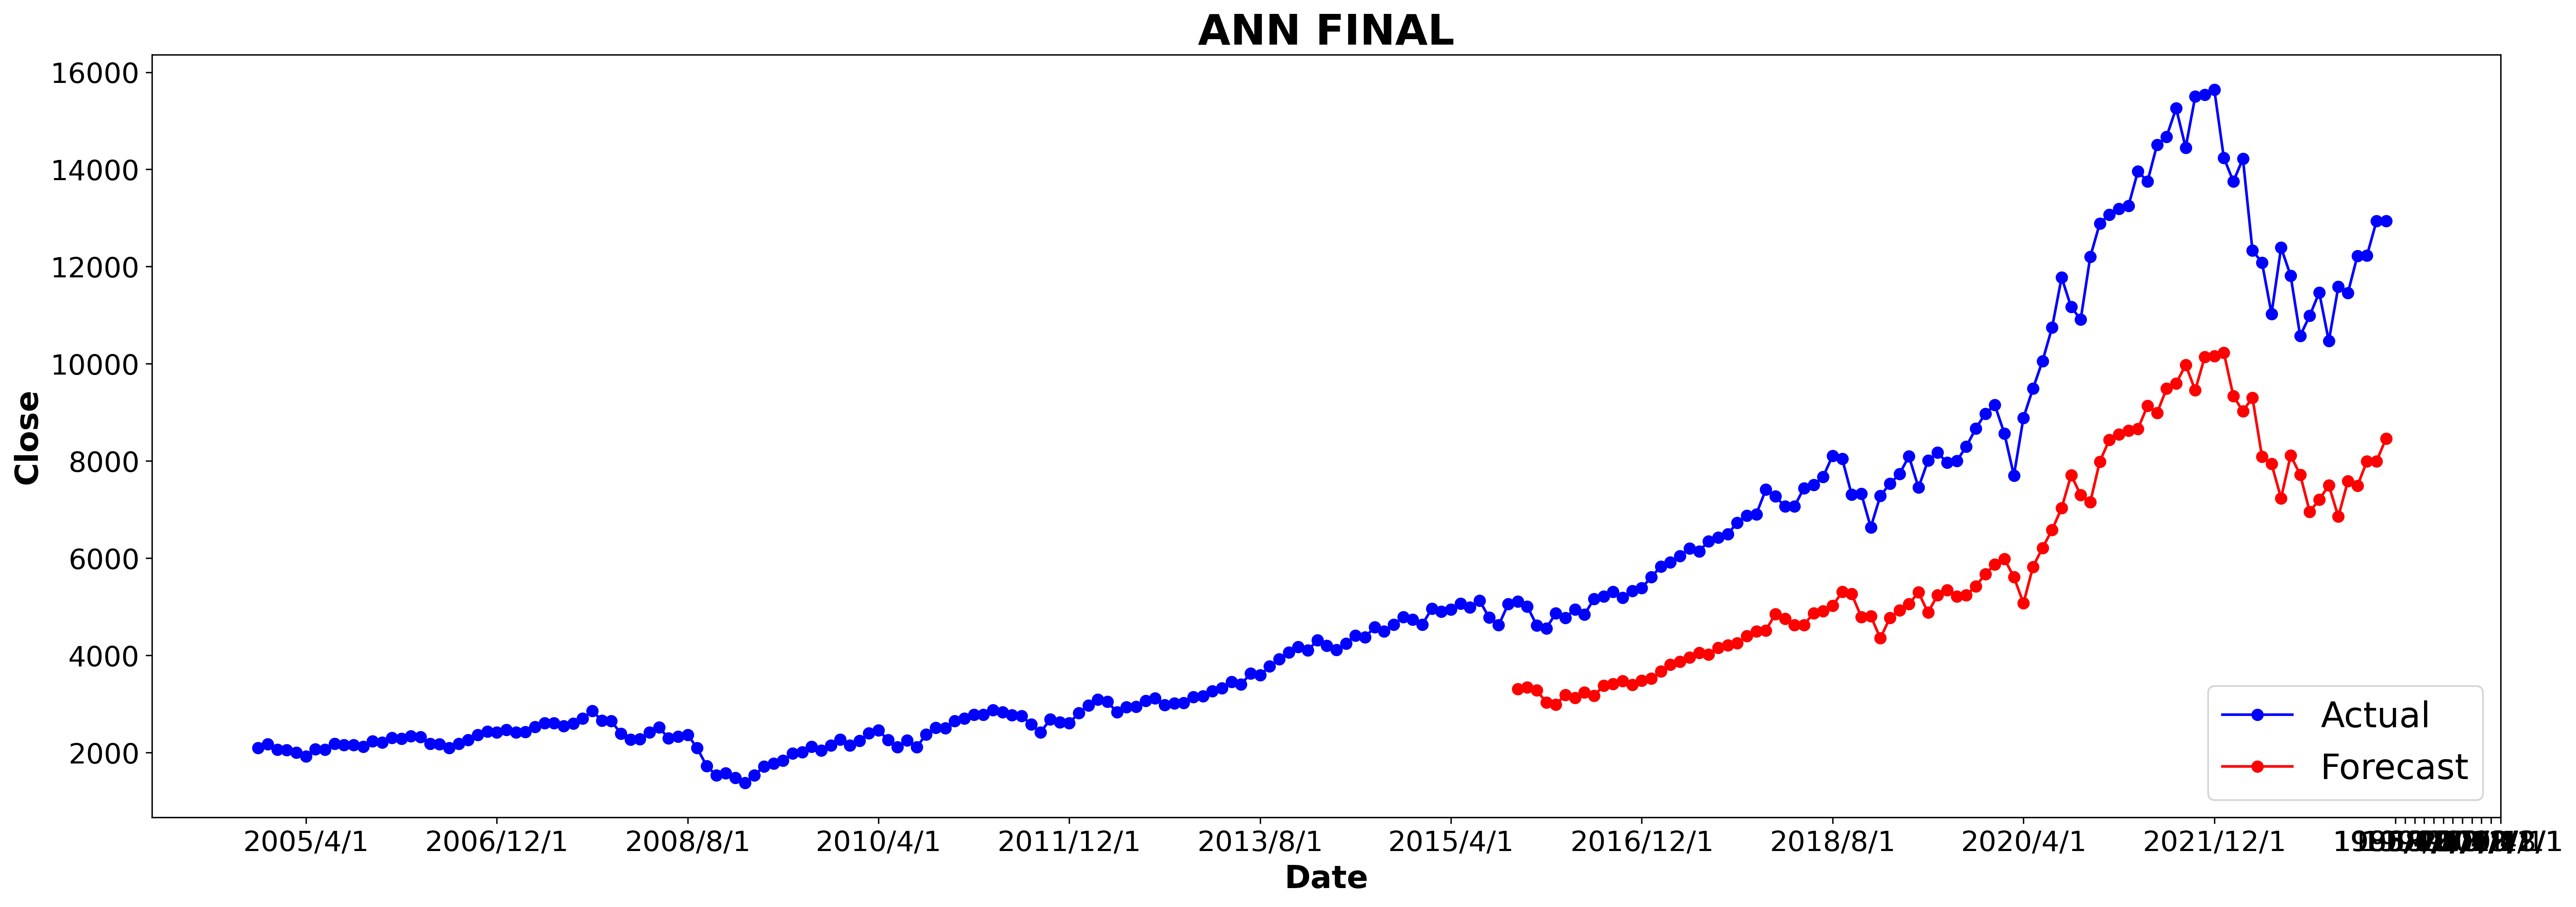

In [56]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('ANN FINAL',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[235:,0],clean_df.iloc[235:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(clean_df['Date'][::20],fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

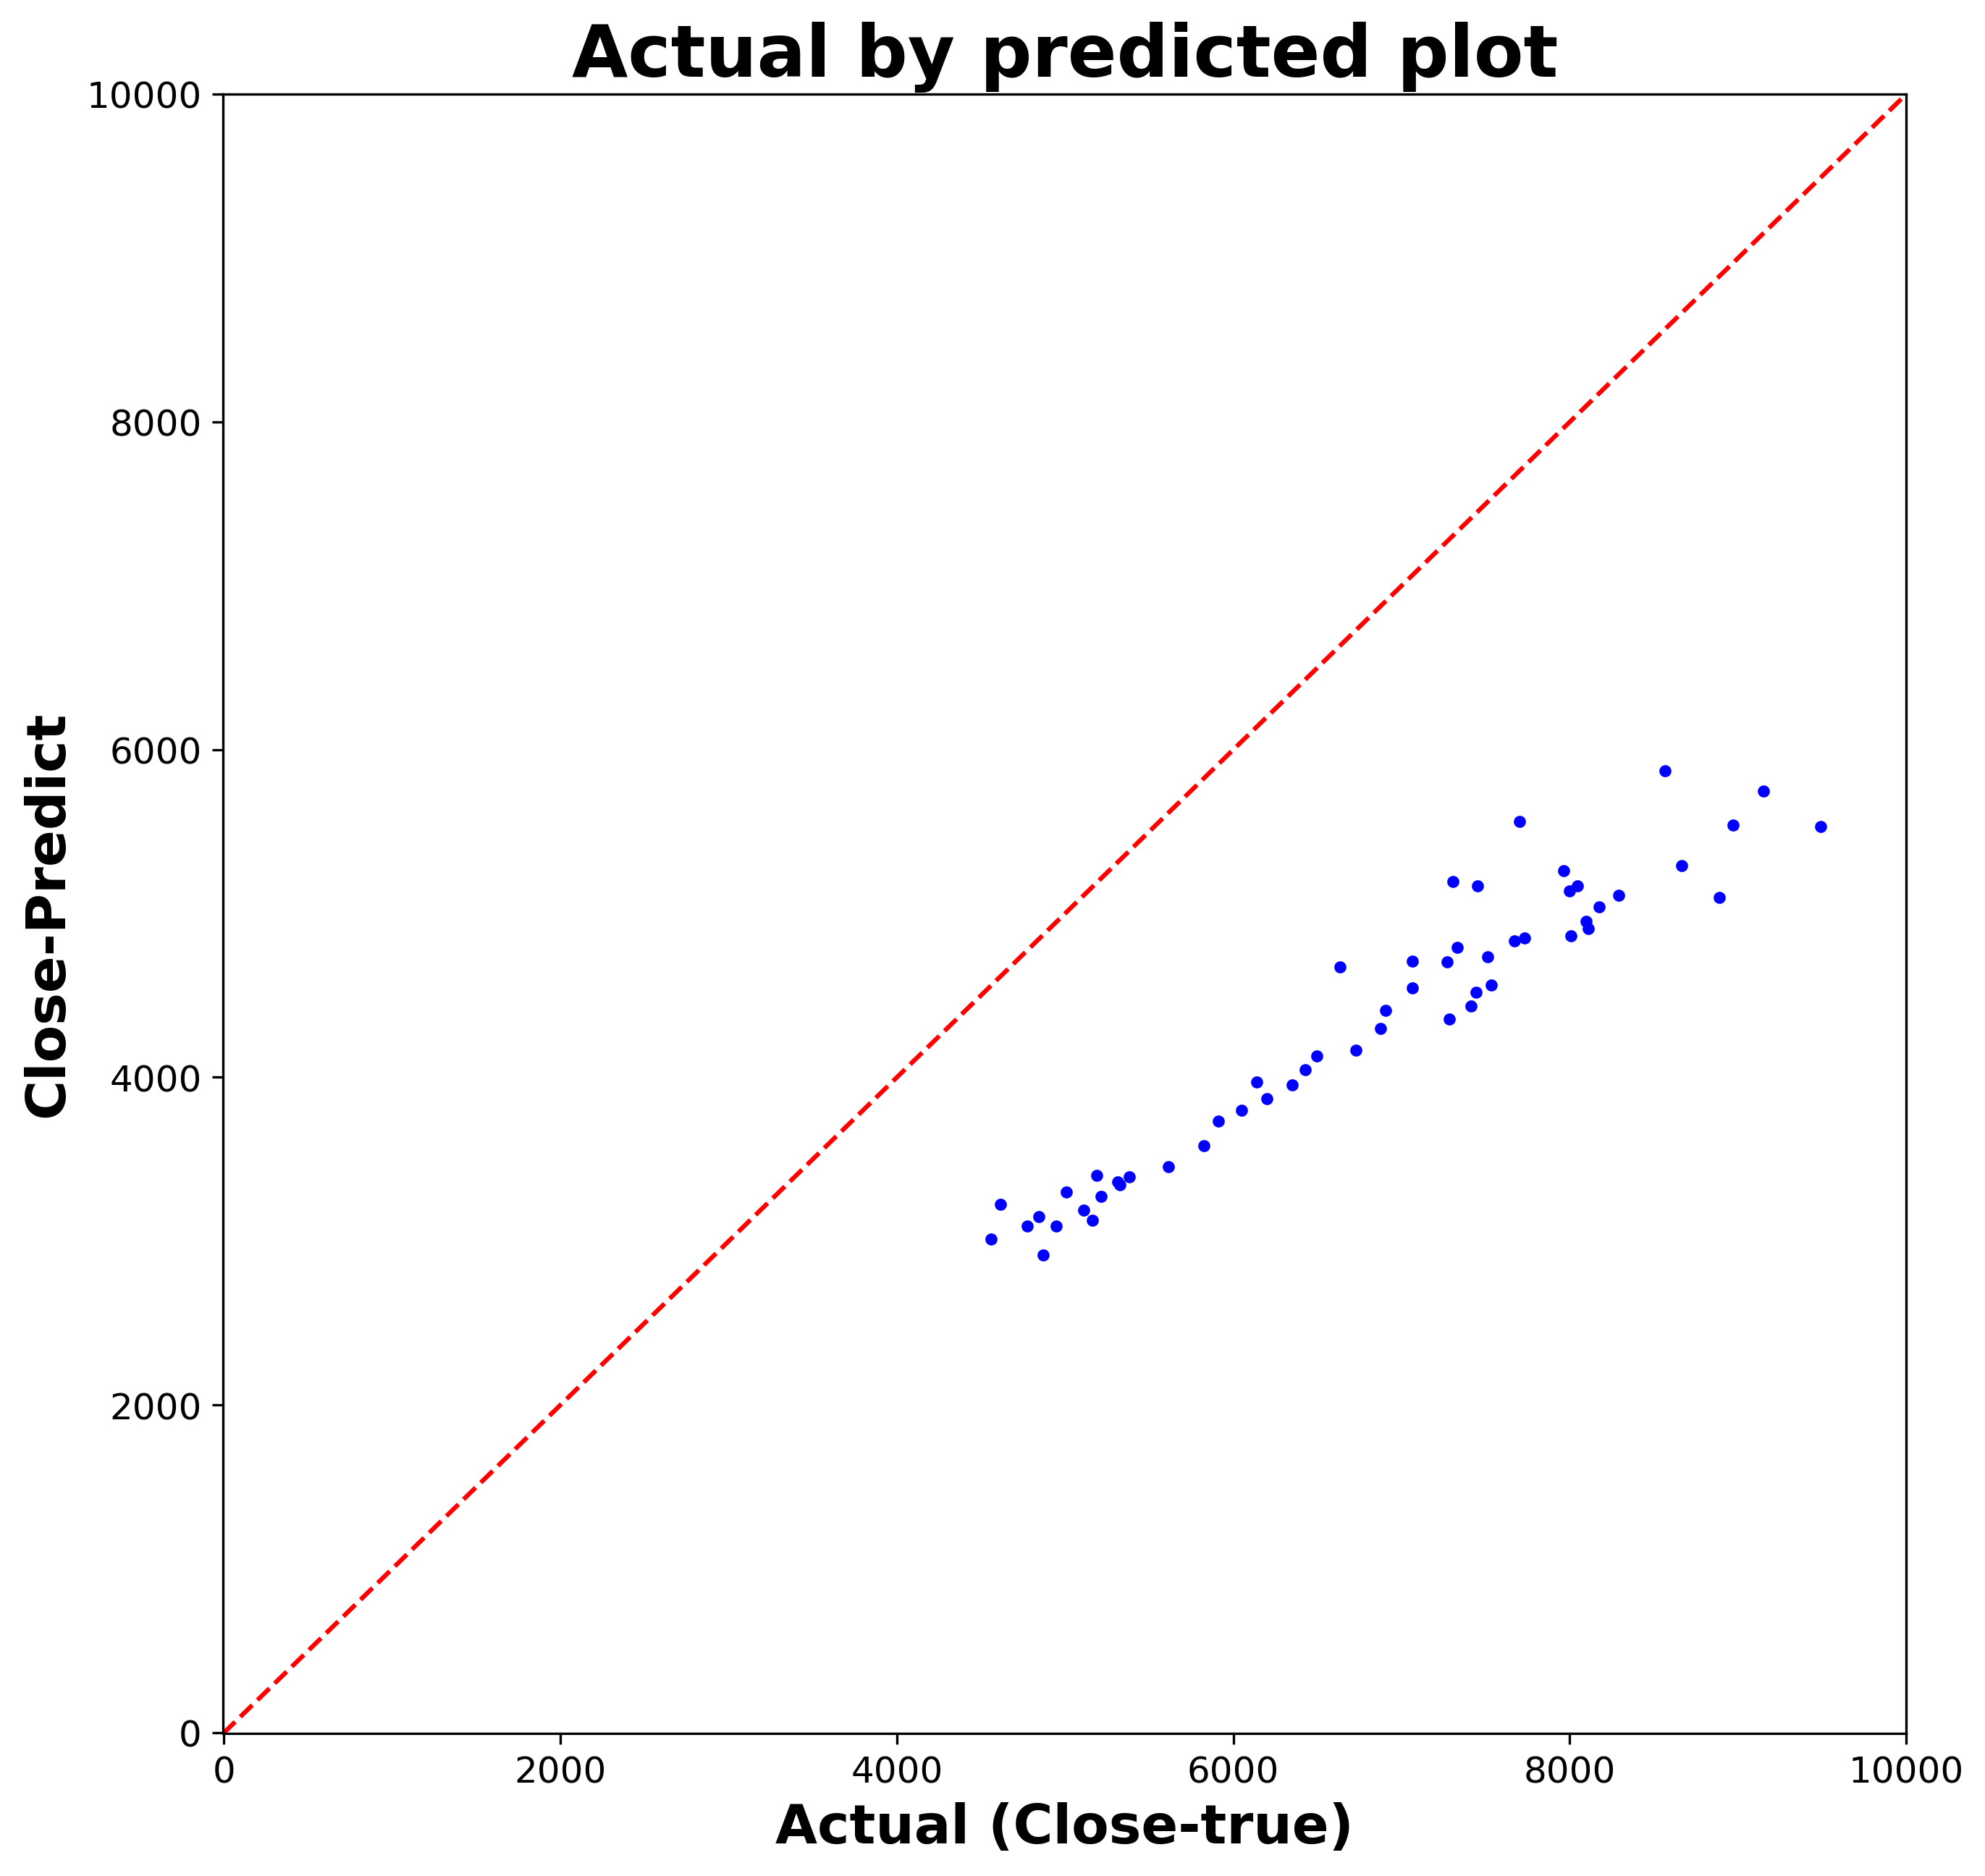

In [32]:
# Lock the scale of axis by Y_true
max_value=10000
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Close-true)',fontsize=18,weight='bold')
plt.ylabel('Close-Predict',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [169]:
exp_5_val = [1975.05, 2216.03, 3598.15]
rol_5_val = [1975.24, 2217.41, 3599.29]
exp_5_mape = [99.95, 99.9, 99.95]
rol_5_mape = [99.95, 99.97, 99.98]


print('exp_5_val:',round(np.mean(exp_5_val),2),'+/-',round(np.std(exp_5_val),2))
print('rol_5_val:',round(np.mean(rol_5_val),2),'+/-',round(np.std(rol_5_val),2))
print('exp_5_mape:',round(np.mean(exp_5_mape),2),'+/-',round(np.std(exp_5_mape),2))
print('rol_5_mape:',round(np.mean(rol_5_mape),2),'+/-',round(np.std(rol_5_mape),2))

exp_5_val: 2596.41 +/- 715.14
rol_5_val: 2597.31 +/- 715.37
exp_5_mape: 99.93 +/- 0.02
rol_5_mape: 99.97 +/- 0.01


In [170]:
exp_3_val = [1291.59, 670.86, 588.86]
rol_3_val = [1135.61, 772.99, 586.82]
exp_3_mape = [40.42, 30.44, 32.27]
rol_3_mape = [33.89, 34.66, 32.08]

print('exp_3_val:',round(np.mean(exp_3_val),2),'+/-',round(np.std(exp_3_val),2))
print('rol_3_val:',round(np.mean(rol_3_val),2),'+/-',round(np.std(rol_3_val),2))
print('exp_3_mape:',round(np.mean(exp_3_mape),2),'+/-',round(np.std(exp_3_mape),2))
print('rol_3_mape:',round(np.mean(rol_3_mape),2),'+/-',round(np.std(rol_3_mape),2))

exp_3_val: 850.44 +/- 313.73
rol_3_val: 831.81 +/- 227.87
exp_3_mape: 34.38 +/- 4.34
rol_3_mape: 33.54 +/- 1.08


In [171]:
exp_4_val = [1072.21, 279.45, 1515.07]
rol_4_val = [852.48, 444.12, 1624.66]
exp_4_mape = [53.99, 13.7, 44.99]
rol_4_mape = [44.04, 20.34, 46.3]

print('exp_4_val:',round(np.mean(exp_4_val),2),'+/-',round(np.std(exp_4_val),2))
print('rol_4_val:',round(np.mean(rol_4_val),2),'+/-',round(np.std(rol_4_val),2))
print('exp_4_mape:',round(np.mean(exp_4_mape),2),'+/-',round(np.std(exp_4_mape),2))
print('rol_4_mape:',round(np.mean(rol_4_mape),2),'+/-',round(np.std(rol_4_mape),2))

exp_4_val: 955.58 +/- 511.14
rol_4_val: 973.75 +/- 489.52
exp_4_mape: 37.56 +/- 17.27
rol_4_mape: 36.89 +/- 11.74
